In [1]:
# import needed libraries
import time
from random import *
from matplotlib import animation, pyplot as plt, colors
import numpy as np
import numba

In [2]:
# gathering information for initializing the forest

GROUND = 0 # represents an empty ground
NON_BURNING_TREE = 1 # represents an area with a non burning tree
BURNING_TREE = 2 # represents an area with a burning tree
BORDERLINE = 3 # represents borderline around the forest

animation_delay = 300 # represents the delay between each frame of the animation in milliseconds, frame means after spread of fire
bounds = [0, 1, 2, 3]
cmap = colors.ListedColormap([(0.2,0,0), (0,0.5,0), (1,0,0), 'orange'])
norm = colors.BoundaryNorm(bounds, cmap.N)
frame_size = 60
plot_size = 12

probTree = 0.8 # represents the probability that a tree initially ocupies the area
probBurning = 0.01 # represents the probability that a tree is burning
probImmune = 0.3 # represents the probability that a tree is immune to fire
probLightning = 0.001 # represents the probability that an area suffered a lightning strike

Non Parallel Simulation of the Spread

In [3]:
# here we create a function to initialize the forest site
def initForestState(sizeOfForest):
    
    # creating a multidimensional array of size sizeOfForest with one row and column
    # of borderline to all sides of the forest.
    # (assumming the site is firstly created with all borderlines),
    forestGrid = np.ones((sizeOfForest + 2, sizeOfForest + 2)) * BORDERLINE
    
    # now we fill the forest with trees, according to the given probabilities above
    # looping through the forest grids (excluding the borders) and assigning the values
    # for the ground, trees and burning trees
    for i in range(1, sizeOfForest + 1):
        for j in range(1, sizeOfForest + 1):
            
            # we check for a burning tree and tree at this position
            # but there has to be a tree, for the tree to be burning
            # so let's check for a tree first
            if random() < probTree:
                if random() < probBurning:
                    # the area contains a burning tree
                    forestGrid[i, j] = BURNING_TREE
                else:
                    # the area contains a non burning tree
                    forestGrid[i, j] = NON_BURNING_TREE
            else:
                # the area is empty
                forestGrid[i, j] = GROUND
                
    # returning the forest grid
    return forestGrid
    

In [4]:
# spread the fire with Moore neighborhood algorithm

def spreadTheFireWithMoore(sizeOfForest, forest):
    
    # looping through the forest grids (excluding the borders)
    for i in range(1, sizeOfForest + 1):
        for j in range(1, sizeOfForest + 1):
            
            # if the area is a tree
            if forest[i,j] == NON_BURNING_TREE:
                    
                # see if there's a burning tree next to the area
                # von Neumann neighborhood are 4-neighborhoods (north, south, east and west) but we won't use them
                # the 8 moore neighborhoods (north, north-east, north-west, south, south-east, south-west, west, east)
                # can tell us if there's a burning tree
                if (forest[i - 1, j] == BURNING_TREE or forest[i + 1, j] == BURNING_TREE or 
                    forest[i, j - 1] == BURNING_TREE or forest[i, j + 1] == BURNING_TREE or 
                    forest[i - 1, j - 1] == BURNING_TREE or forest[i - 1, j + 1] == BURNING_TREE or 
                    forest[i + 1, j - 1] == BURNING_TREE or forest[i + 1, j + 1] == BURNING_TREE):
    
                    # if the area is immune to fire the tree does not burn
                    if random() < probImmune:
                        forest[i,j] = NON_BURNING_TREE
                    else:
                        forest[i,j] = BURNING_TREE
                        
                # if the area suffered a lightning strike the tree burns
                elif random() < probLightning:
                    
                    # if the area is immune to fire the tree does not burn
                    if random() < probImmune:
                        forest[i,j] = NON_BURNING_TREE
                    else:
                        forest[i,j] = BURNING_TREE
                
                # else the tree doesn't burn cause there are burning influences
                else:
                    forest[i, j] = NON_BURNING_TREE 
            
            # if the area is already a burning tree, then the tree burns to the ground
            elif forest[i, j] == BURNING_TREE:
                forest[i, j] = GROUND
            
            # otherwise the area remains empty if it's a ground
            else:
                forest[i, j] = GROUND
            
    return forest

In [5]:
def VisualizeForestFireSpread(sizeOfForest, forest):
    
    # select only the forest site with no borderlines
    Onlyforest = forest[1:sizeOfForest + 1, 1:sizeOfForest + 1]
    
    # extend the grid using periodic boundary conditions
    
    # extending the boundary rows with ghost areas so that we can spread the fire at the site borders too.
    rowStack = np.row_stack((Onlyforest[-1,:], Onlyforest, Onlyforest[0,:]))
    
    # extending the boundary columns with ghost areas so that we can spread the fire at the site borders too.
    forestAfterExtension = np.column_stack((rowStack[:,-1], rowStack, rowStack[:,0]))
    
    # now we can spread the fire  
    appliedSpreadForest = spreadTheFireWithMoore(sizeOfForest, forestAfterExtension)
    
    # remove the ghost areas and return the borderline before plotting
    Onlyforest = appliedSpreadForest[1:sizeOfForest + 1, 1:sizeOfForest + 1]
    forest[1:sizeOfForest + 1, 1:sizeOfForest + 1] = Onlyforest
        
    return forest

Time elapsed for applying the spread on forest grid size 100: 0.08499670028686523 seconds


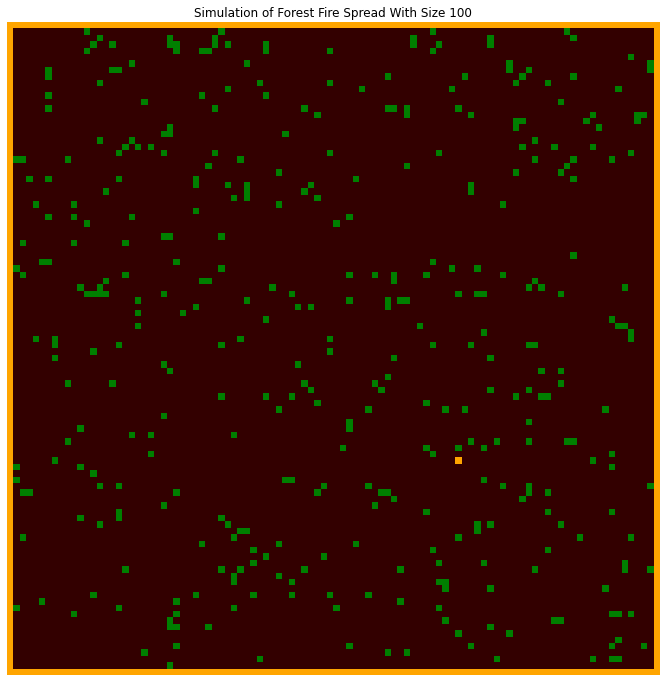

In [6]:
startTime = time.time()
gridSize = 100
fig_no = 1

forest = initForestState(gridSize)

forest_test = VisualizeForestFireSpread(gridSize, forest)

timeElapsed = time.time() - startTime
print("Time elapsed for applying the spread on forest grid size {0}: {1} seconds".format(gridSize, timeElapsed))

fig = plt.figure(num=fig_no, figsize=(plot_size, plot_size))
ax = fig.add_subplot(111)
ax.set_title('Simulation of Forest Fire Spread With Size {0}'.format(gridSize))
ax.set_axis_off()
    
# plot the forest
forestGridVisual = ax.imshow(forest, cmap=cmap, norm=norm)
    
def animate(i):
    forestGridVisual.set_array(animate.forest)
    animate.forest = VisualizeForestFireSpread(gridSize, animate.forest)

animate.forest = forest

anim = animation.FuncAnimation(fig, animate, interval=animation_delay, frames=frame_size)

# saving the animation as an mp4 video file
anim.save('fire_spread_animation{0}.gif'.format(gridSize))

plt.show()

Time elapsed for applying the spread on forest grid size 400: 0.6515018939971924 seconds


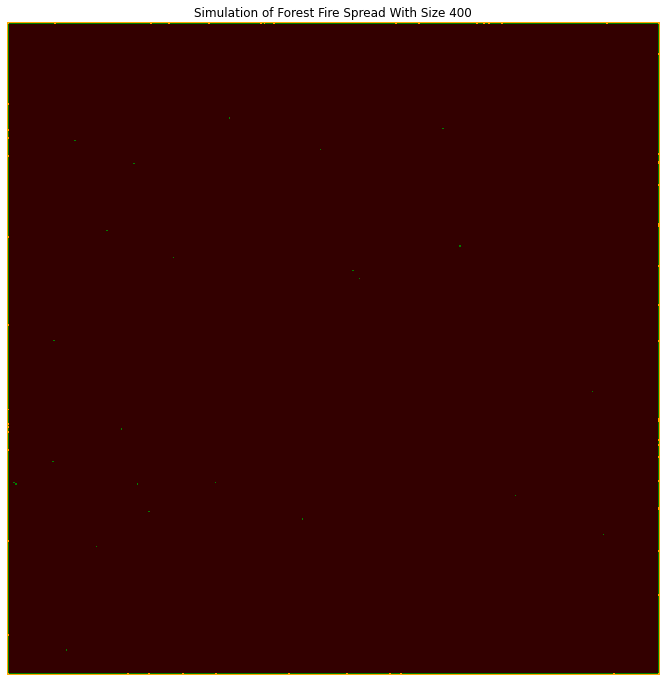

In [7]:
startTime = time.time()
gridSize = 400
fig_no = 2

forest = initForestState(gridSize)

forest_test = VisualizeForestFireSpread(gridSize, forest)

timeElapsed = time.time() - startTime
print("Time elapsed for applying the spread on forest grid size {0}: {1} seconds".format(gridSize, timeElapsed))

fig = plt.figure(num=fig_no, figsize=(plot_size, plot_size))
ax = fig.add_subplot(111)
ax.set_title('Simulation of Forest Fire Spread With Size {0}'.format(gridSize))
ax.set_axis_off()
    
# plot the forest
forestGridVisual = ax.imshow(forest, cmap=cmap, norm=norm)
    
def animate(i):
    forestGridVisual.set_array(animate.forest)
    animate.forest = VisualizeForestFireSpread(gridSize, animate.forest)

animate.forest = forest

anim = animation.FuncAnimation(fig, animate, interval=animation_delay, frames=frame_size)

# saving the animation as an mp4 video file
anim.save('fire_spread_animation{0}.gif'.format(gridSize))

plt.show()

Time elapsed for applying the spread on forest grid size 800: 2.6593780517578125 seconds


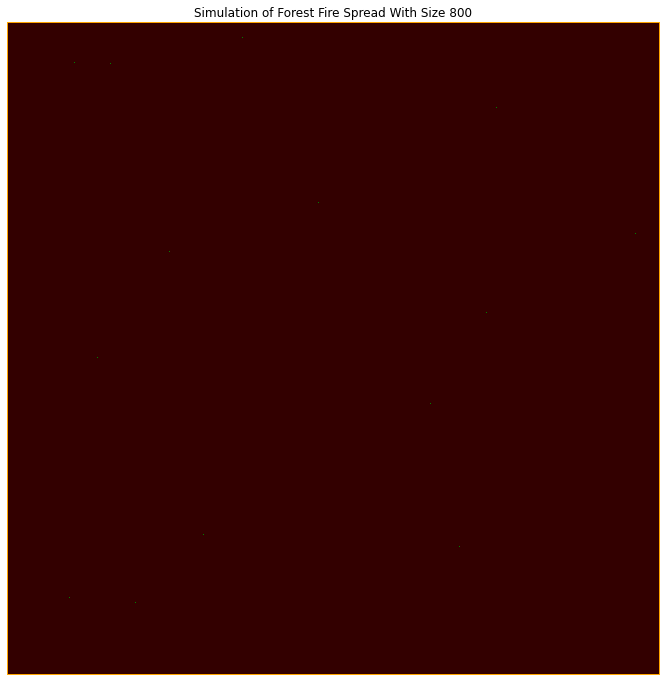

In [8]:
startTime = time.time()
gridSize = 800
fig_no = 3

forest = initForestState(gridSize)

forest_test = VisualizeForestFireSpread(gridSize, forest)

timeElapsed = time.time() - startTime
print("Time elapsed for applying the spread on forest grid size {0}: {1} seconds".format(gridSize, timeElapsed))

fig = plt.figure(num=fig_no, figsize=(plot_size, plot_size))
ax = fig.add_subplot(111)
ax.set_title('Simulation of Forest Fire Spread With Size {0}'.format(gridSize))
ax.set_axis_off()
    
# plot the forest
forestGridVisual = ax.imshow(forest, cmap=cmap, norm=norm)
    
def animate(i):
    forestGridVisual.set_array(animate.forest)
    animate.forest = VisualizeForestFireSpread(gridSize, animate.forest)

animate.forest = forest

anim = animation.FuncAnimation(fig, animate, interval=animation_delay, frames=frame_size)

# saving the animation as an mp4 video file
anim.save('fire_spread_animation{0}.gif'.format(gridSize))

plt.show()

Time elapsed for applying the spread on forest grid size 1000: 4.661702394485474 seconds


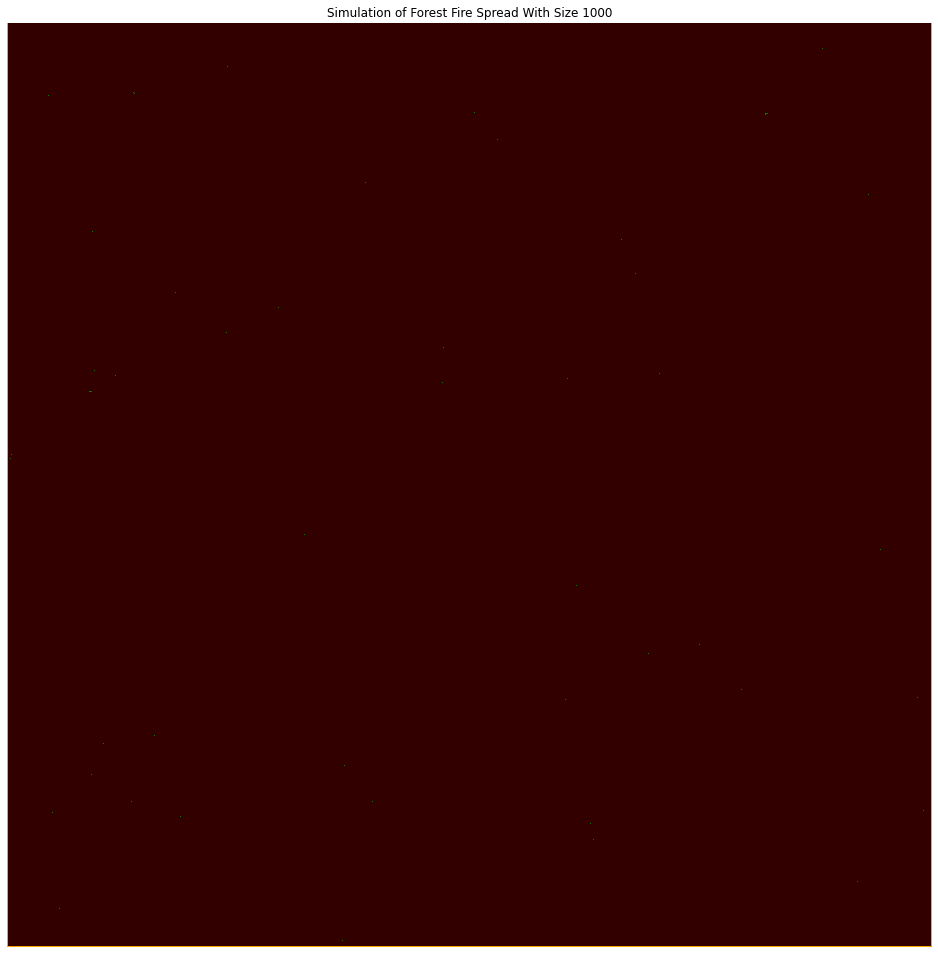

In [9]:
startTime = time.time()
gridSize = 1000
fig_no = 4

forest = initForestState(gridSize)

forest_test = VisualizeForestFireSpread(gridSize, forest)

timeElapsed = time.time() - startTime
print("Time elapsed for applying the spread on forest grid size {0}: {1} seconds".format(gridSize, timeElapsed))

fig = plt.figure(num=fig_no, figsize=(plot_size+5, plot_size+5))
ax = fig.add_subplot(111)
ax.set_title('Simulation of Forest Fire Spread With Size {0}'.format(gridSize))
ax.set_axis_off()
    
# plot the forest
forestGridVisual = ax.imshow(forest, cmap=cmap, norm=norm)
    
def animate(i):
    forestGridVisual.set_array(animate.forest)
    animate.forest = VisualizeForestFireSpread(gridSize, animate.forest)

animate.forest = forest

anim = animation.FuncAnimation(fig, animate, interval=animation_delay, frames=frame_size)

# saving the animation as an mp4 video file
anim.save('fire_spread_animation{0}.gif'.format(gridSize))

plt.show()

Time elapsed for applying the spread on forest grid size 1200: 6.523056507110596 seconds


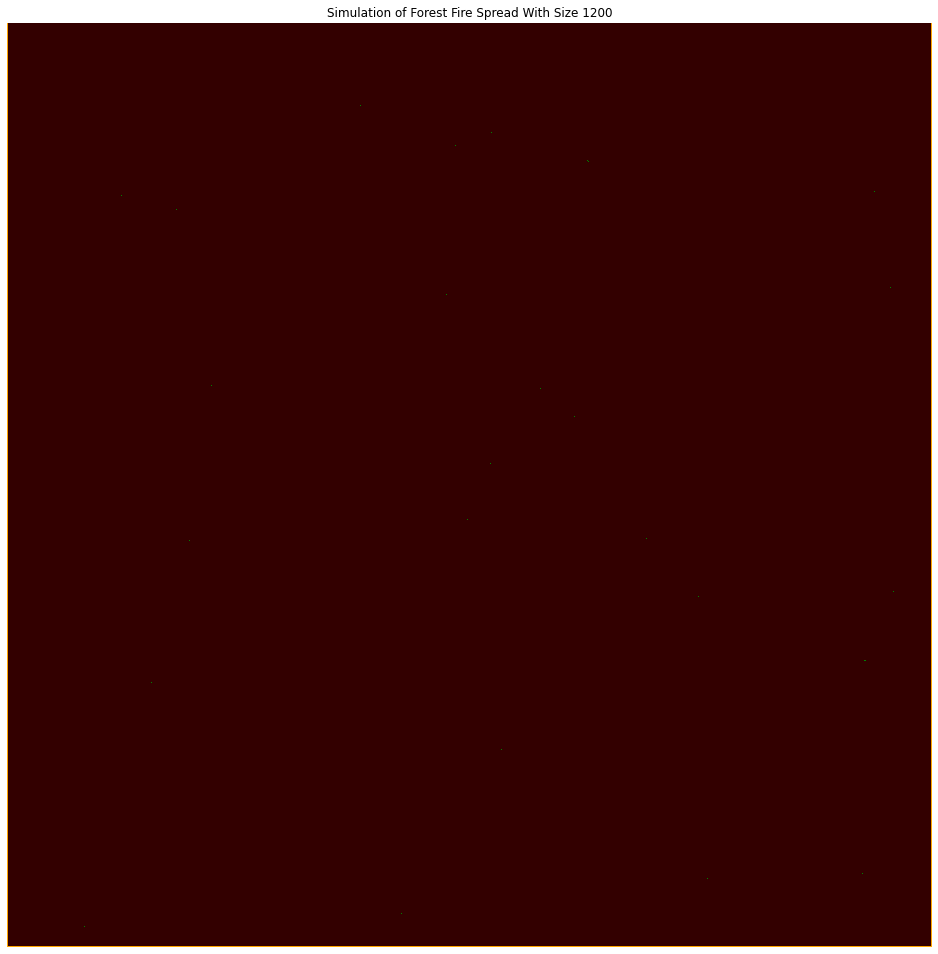

In [10]:
startTime = time.time()
gridSize = 1200
fig_no = 5

forest = initForestState(gridSize)

forest_test = VisualizeForestFireSpread(gridSize, forest)

timeElapsed = time.time() - startTime
print("Time elapsed for applying the spread on forest grid size {0}: {1} seconds".format(gridSize, timeElapsed))

fig = plt.figure(num=fig_no, figsize=(plot_size+5, plot_size+5))
ax = fig.add_subplot(111)
ax.set_title('Simulation of Forest Fire Spread With Size {0}'.format(gridSize))
ax.set_axis_off()
    
# plot the forest
forestGridVisual = ax.imshow(forest, cmap=cmap, norm=norm)
    
def animate(i):
    forestGridVisual.set_array(animate.forest)
    animate.forest = VisualizeForestFireSpread(gridSize, animate.forest)

animate.forest = forest

anim = animation.FuncAnimation(fig, animate, interval=animation_delay, frames=frame_size)

# saving the animation as an mp4 video file
anim.save('fire_spread_animation{0}.gif'.format(gridSize))

plt.show()

Time elapsed for applying the spread on forest grid size 2000: 17.282514333724976 seconds


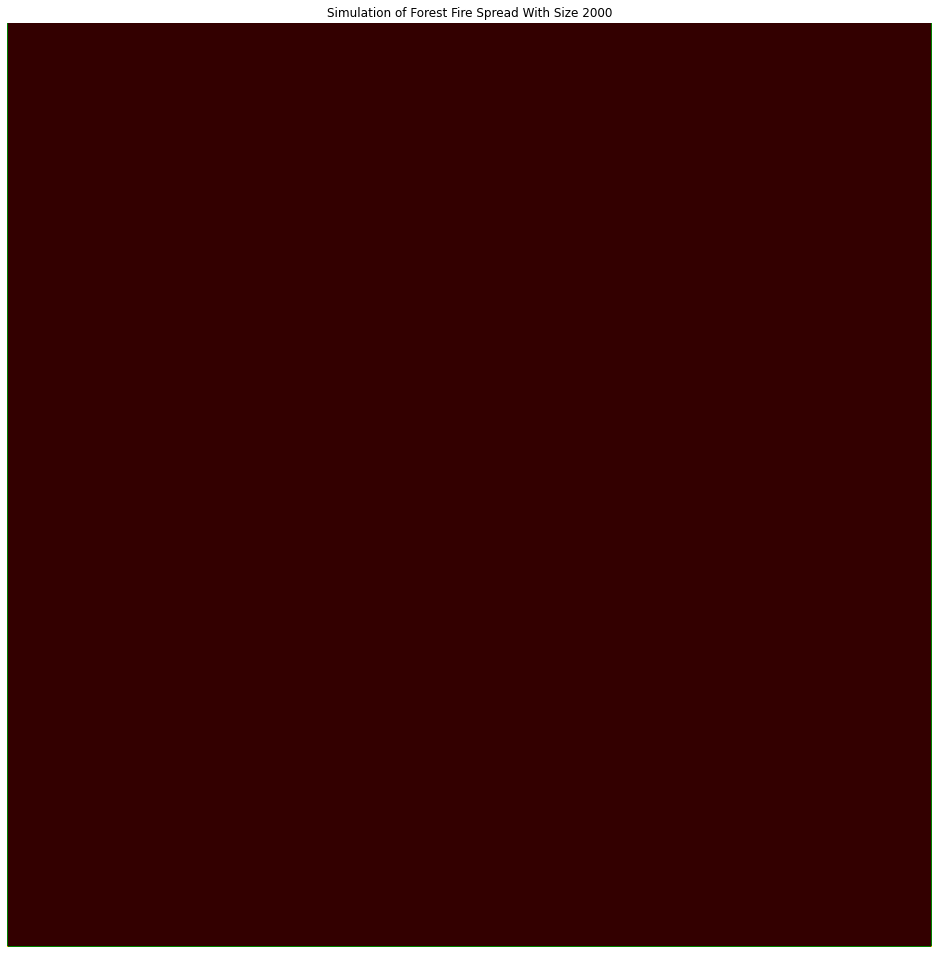

In [11]:
startTime = time.time()
gridSize = 2000
fig_no = 6

forest = initForestState(gridSize)

forest_test = VisualizeForestFireSpread(gridSize, forest)

timeElapsed = time.time() - startTime
print("Time elapsed for applying the spread on forest grid size {0}: {1} seconds".format(gridSize, timeElapsed))

fig = plt.figure(num=fig_no, figsize=(plot_size+5, plot_size+5))
ax = fig.add_subplot(111)
ax.set_title('Simulation of Forest Fire Spread With Size {0}'.format(gridSize))
ax.set_axis_off()
    
# plot the forest
forestGridVisual = ax.imshow(forest, cmap=cmap, norm=norm)
    
def animate(i):
    forestGridVisual.set_array(animate.forest)
    animate.forest = VisualizeForestFireSpread(gridSize, animate.forest)

animate.forest = forest

anim = animation.FuncAnimation(fig, animate, interval=animation_delay, frames=frame_size)

# saving the animation as an mp4 video file
anim.save('fire_spread_animation{0}.gif'.format(gridSize))

plt.show()

Parallelizing the Simulation of the Spread

In [12]:
# Parallelizing the initForestState function

numba.jit(nopython=True, parallel=True)
def initForestState_Parallel(sizeOfForest):
    
    # creating a multidimensional array of size sizeOfForest with one row and column
    # of borderline to all sides of the forest.
    # (assumming the site is firstly created with all borderlines),
    forestGrid = np.ones((sizeOfForest + 2, sizeOfForest + 2)) * BORDERLINE
    
    # now we fill the forest with trees, according to the given probabilities above
    # looping through the forest grids (excluding the borders) and assigning the values
    # for the ground, trees and burning trees
    for i in numba.prange(1, sizeOfForest + 1):
        for j in numba.prange(1, sizeOfForest + 1):
            
            # we check for a burning tree and tree at this position
            # but there has to be a tree, for the tree to be burning
            # so let's check for a tree first
            if random() < probTree:
                if random() < probBurning:
                    # the area contains a burning tree
                    forestGrid[i, j] = BURNING_TREE
                else:
                    # the area contains a non burning tree
                    forestGrid[i, j] = NON_BURNING_TREE
            else:
                # the area is empty
                forestGrid[i, j] = GROUND
                
    # returning the forest grid
    return forestGrid
    

In [13]:
# Parallelizing the spread of the fire with Moore neighborhood algorithm

numba.jit(nopython=True, parallel=True)
def spreadTheFireWithMoore_Parallel(sizeOfForest, forestGrid):
    
    for i in numba.prange(1, sizeOfForest + 1):
        for j in numba.prange(1, sizeOfForest + 1):
            
            # if the area is a tree
            if forestGrid[i,j] == NON_BURNING_TREE:
                    
                # see if there's a burning tree next to the area
                # von Neumann neighborhood are 4-neighborhoods (north, south, east and west) but we won't use them
                # the 8 moore neighborhoods (north, north-east, north-west, south, south-east, south-west, west, east)
                # can tell us if there's a burning tree
                if (forestGrid[i - 1, j] == BURNING_TREE or forestGrid[i + 1, j] == BURNING_TREE or 
                    forestGrid[i, j - 1] == BURNING_TREE or forestGrid[i, j + 1] == BURNING_TREE or 
                    forestGrid[i - 1, j - 1] == BURNING_TREE or forestGrid[i - 1, j + 1] == BURNING_TREE or 
                    forestGrid[i + 1, j - 1] == BURNING_TREE or forestGrid[i + 1, j + 1] == BURNING_TREE):
    
                    # if the area is immune to fire the tree does not burn
                    if random() < probImmune:
                        forestGrid[i,j] = NON_BURNING_TREE
                    else:
                        forestGrid[i,j] = BURNING_TREE
                        
                # if the area suffered a lightning strike the tree burns
                elif random() < probLightning:
                    
                    # if the area is immune to fire the tree does not burn
                    if random() < probImmune:
                        forestGrid[i,j] = NON_BURNING_TREE
                    else:
                        forestGrid[i,j] = BURNING_TREE
                
                # else the tree doesn't burn cause there are burning influences
                else:
                    forestGrid[i, j] = NON_BURNING_TREE 
            
            # if the area is already a burning tree, then the tree burns to the ground
            elif forestGrid[i, j] == BURNING_TREE:
                forestGrid[i, j] = GROUND
            
            # otherwise the area remains empty if it's a ground
            else:
                forestGrid[i, j] = GROUND
            
    return forestGrid

In [14]:
numba.jit(nopython=True, parallel=True)
def VisualizeForestFireSpread_Parallel(sizeOfForest, forest):
    
    # select only the forest site with no borderlines
    Onlyforest = forest[1:sizeOfForest + 1, 1:sizeOfForest + 1]
    
    # extend the grid using periodic boundary conditions
    
    # extending the boundary rows with ghost areas so that we can spread the fire at the site borders too.
    rowStack = np.row_stack((Onlyforest[-1,:], Onlyforest, Onlyforest[0,:]))
    
    # extending the boundary columns with ghost areas so that we can spread the fire at the site borders too.
    forestAfterExtension = np.column_stack((rowStack[:,-1], rowStack, rowStack[:,0]))
    
    # now we can spread the fire  
    appliedSpreadForest = spreadTheFireWithMoore_Parallel(sizeOfForest, forestAfterExtension)
    
    # remove the ghost areas and return the borderline before plotting
    Onlyforest = appliedSpreadForest[1:sizeOfForest + 1, 1:sizeOfForest + 1]
    forest[1:sizeOfForest + 1, 1:sizeOfForest + 1] = Onlyforest
        
    return forest

Time elapsed for applying the spread (Parallel) on forest grid size 100: 0.06099867820739746 seconds


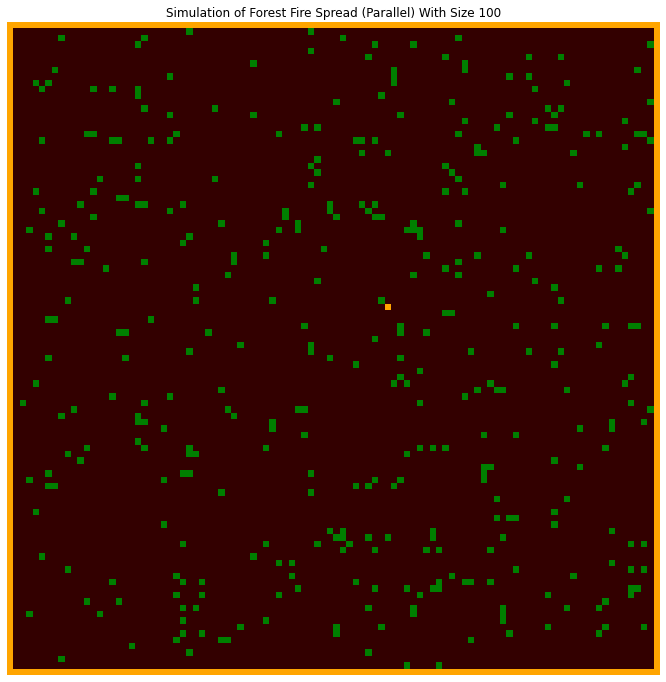

In [21]:
gridSize = 100

# compilling the functions before use
forest = initForestState_Parallel(gridSize)
forest_test = VisualizeForestFireSpread_Parallel(gridSize, forest)

startTime = time.time()
fig_no = 7

forest = initForestState_Parallel(gridSize)

forest_test = VisualizeForestFireSpread_Parallel(gridSize, forest)

timeElapsed = time.time() - startTime
print("Time elapsed for applying the spread (Parallel) on forest grid size {0}: {1} seconds".format(gridSize, timeElapsed))

fig = plt.figure(num=fig_no, figsize=(plot_size, plot_size))
ax = fig.add_subplot(111)
ax.set_title('Simulation of Forest Fire Spread (Parallel) With Size {0}'.format(gridSize))
ax.set_axis_off()
    
# plot the forest
forestGridVisual = ax.imshow(forest, cmap=cmap, norm=norm)
    
def animate(i):
    forestGridVisual.set_array(animate.forest)
    animate.forest = VisualizeForestFireSpread_Parallel(gridSize, animate.forest)

animate.forest = forest

anim = animation.FuncAnimation(fig, animate, interval=animation_delay, frames=frame_size)

# saving the animation as an mp4 video file
anim.save('fire_spread_animation_{0}__with_parallel.gif'.format(gridSize))

plt.show()

Time elapsed for applying the spread (Parallel) on forest grid size 400: 0.6148388385772705 seconds


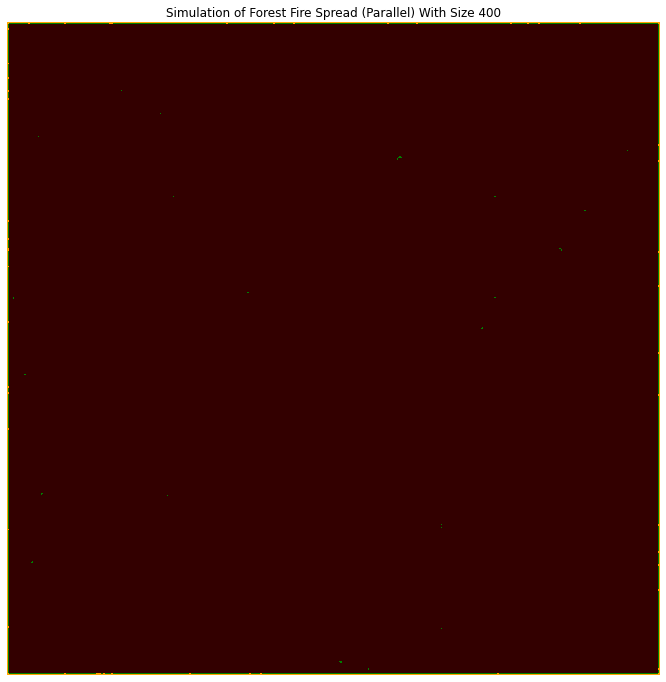

In [22]:
startTime = time.time()
gridSize = 400
fig_no = 8

forest = initForestState_Parallel(gridSize)

forest_test = VisualizeForestFireSpread_Parallel(gridSize, forest)

timeElapsed = time.time() - startTime
print("Time elapsed for applying the spread (Parallel) on forest grid size {0}: {1} seconds".format(gridSize, timeElapsed))

fig = plt.figure(num=fig_no, figsize=(plot_size, plot_size))
ax = fig.add_subplot(111)
ax.set_title('Simulation of Forest Fire Spread (Parallel) With Size {0}'.format(gridSize))
ax.set_axis_off()
    
# plot the forest
forestGridVisual = ax.imshow(forest, cmap=cmap, norm=norm)
    
def animate(i):
    forestGridVisual.set_array(animate.forest)
    animate.forest = VisualizeForestFireSpread_Parallel(gridSize, animate.forest)

animate.forest = forest

anim = animation.FuncAnimation(fig, animate, interval=animation_delay, frames=frame_size)

# saving the animation as an mp4 video file
anim.save('fire_spread_animation_{0}__with_parallel.gif'.format(gridSize))

plt.show()

Time elapsed for applying the spread (Parallel) on forest grid size 800: 2.4354398250579834 seconds


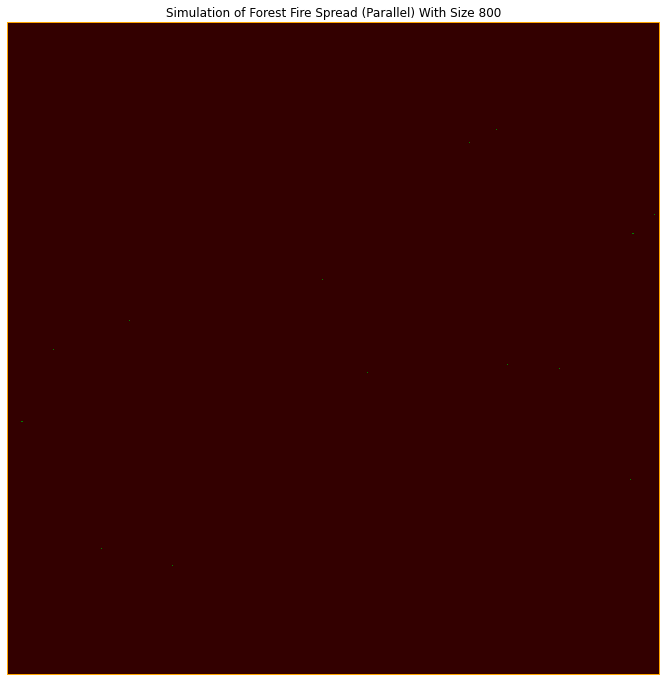

In [23]:
startTime = time.time()
gridSize = 800
fig_no = 9

forest = initForestState_Parallel(gridSize)

forest_test = VisualizeForestFireSpread_Parallel(gridSize, forest)

timeElapsed = time.time() - startTime
print("Time elapsed for applying the spread (Parallel) on forest grid size {0}: {1} seconds".format(gridSize, timeElapsed))

fig = plt.figure(num=fig_no, figsize=(plot_size, plot_size))
ax = fig.add_subplot(111)
ax.set_title('Simulation of Forest Fire Spread (Parallel) With Size {0}'.format(gridSize))
ax.set_axis_off()
    
# plot the forest
forestGridVisual = ax.imshow(forest, cmap=cmap, norm=norm)
    
def animate(i):
    forestGridVisual.set_array(animate.forest)
    animate.forest = VisualizeForestFireSpread_Parallel(gridSize, animate.forest)

animate.forest = forest

anim = animation.FuncAnimation(fig, animate, interval=animation_delay, frames=frame_size)

# saving the animation as an mp4 video file
anim.save('fire_spread_animation_{0}__with_parallel.gif'.format(gridSize))

plt.show()

Time elapsed for applying the spread (Parallel) on forest grid size 1000: 3.762147903442383 seconds


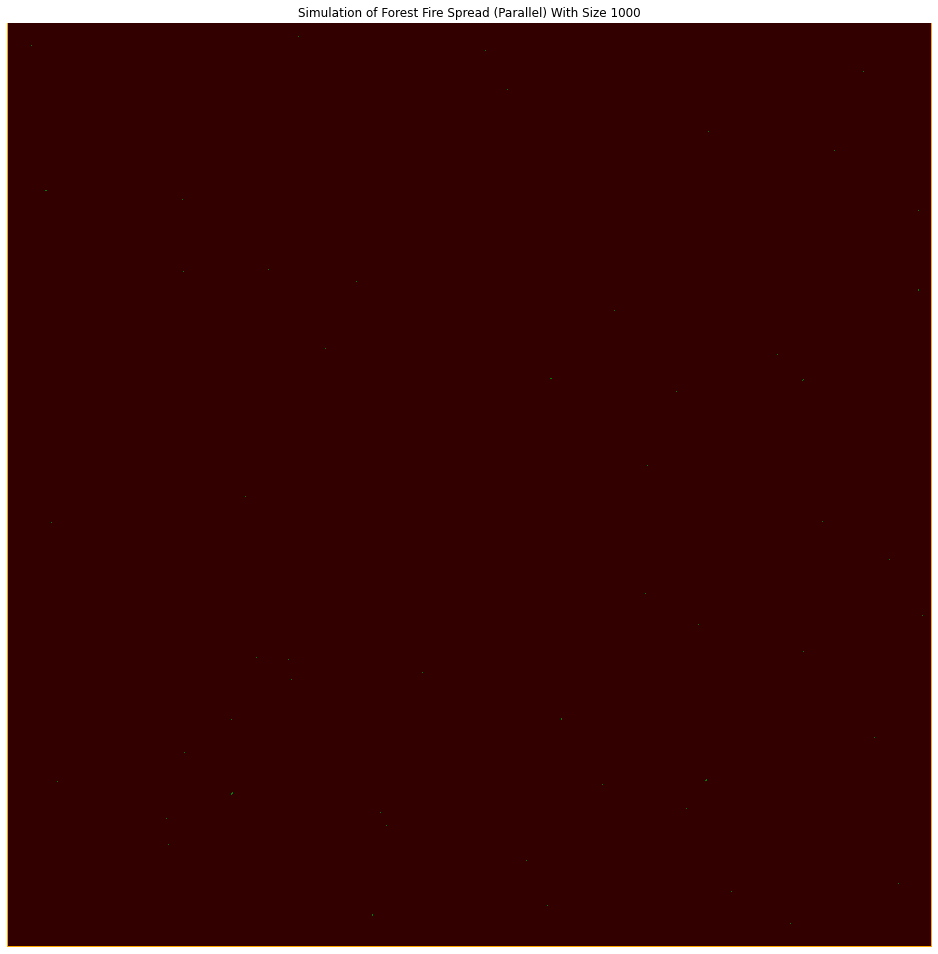

In [24]:
startTime = time.time()
gridSize = 1000
fig_no = 10

forest = initForestState_Parallel(gridSize)

forest_test = VisualizeForestFireSpread_Parallel(gridSize, forest)

timeElapsed = time.time() - startTime
print("Time elapsed for applying the spread (Parallel) on forest grid size {0}: {1} seconds".format(gridSize, timeElapsed))

fig = plt.figure(num=fig_no, figsize=(plot_size + 5, plot_size + 5))
ax = fig.add_subplot(111)
ax.set_title('Simulation of Forest Fire Spread (Parallel) With Size {0}'.format(gridSize))
ax.set_axis_off()
    
# plot the forest
forestGridVisual = ax.imshow(forest, cmap=cmap, norm=norm)
    
def animate(i):
    forestGridVisual.set_array(animate.forest)
    animate.forest = VisualizeForestFireSpread_Parallel(gridSize, animate.forest)

animate.forest = forest

anim = animation.FuncAnimation(fig, animate, interval=animation_delay, frames=frame_size)

# saving the animation as an mp4 video file
anim.save('fire_spread_animation_{0}__with_parallel.gif'.format(gridSize))

plt.show()

Time elapsed for applying the spread (Parallel) on forest grid size 1200: 5.9244468212127686 seconds


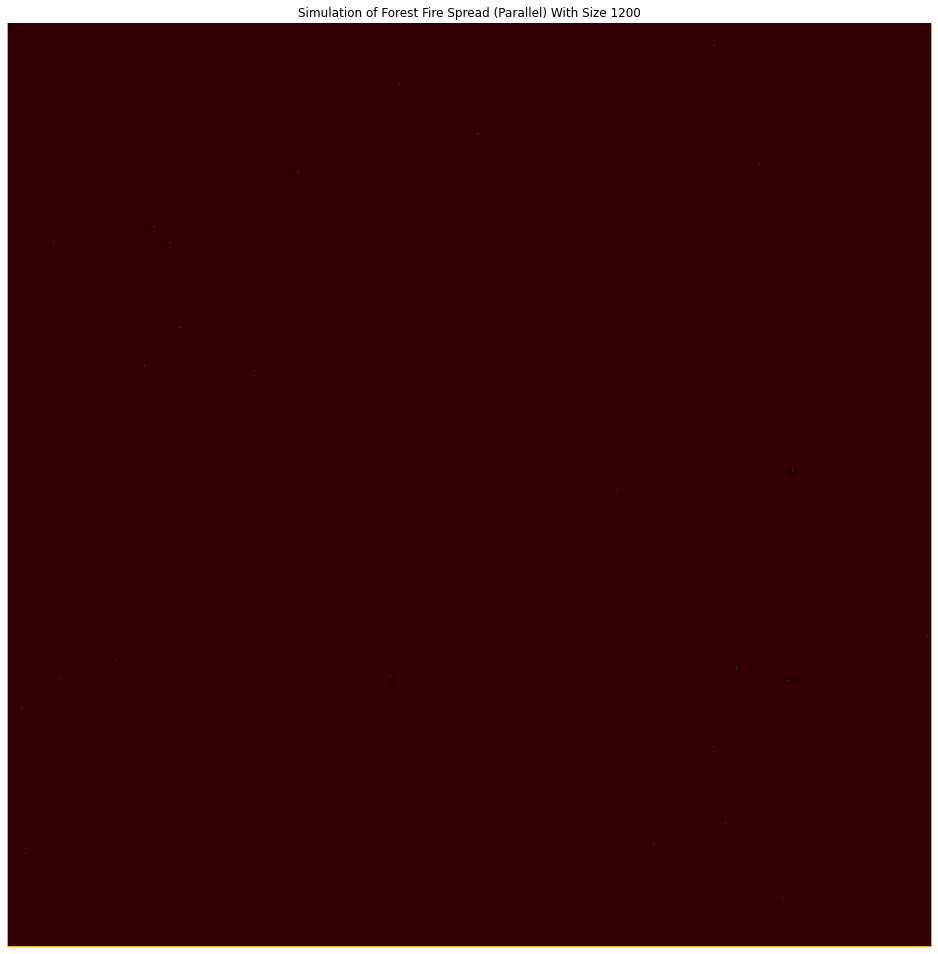

In [25]:
startTime = time.time()
gridSize = 1200
fig_no = 11

forest = initForestState_Parallel(gridSize)

forest_test = VisualizeForestFireSpread_Parallel(gridSize, forest)

timeElapsed = time.time() - startTime
print("Time elapsed for applying the spread (Parallel) on forest grid size {0}: {1} seconds".format(gridSize, timeElapsed))

fig = plt.figure(num=fig_no, figsize=(plot_size + 5, plot_size + 5))
ax = fig.add_subplot(111)
ax.set_title('Simulation of Forest Fire Spread (Parallel) With Size {0}'.format(gridSize))
ax.set_axis_off()
    
# plot the forest
forestGridVisual = ax.imshow(forest, cmap=cmap, norm=norm)
    
def animate(i):
    forestGridVisual.set_array(animate.forest)
    animate.forest = VisualizeForestFireSpread_Parallel(gridSize, animate.forest)

animate.forest = forest

anim = animation.FuncAnimation(fig, animate, interval=animation_delay, frames=frame_size)

# saving the animation as an mp4 video file
anim.save('fire_spread_animation_{0}__with_parallel.gif'.format(gridSize))

plt.show()

Time elapsed for applying the spread (Parallel) on forest grid size 2000: 17.065704107284546 seconds


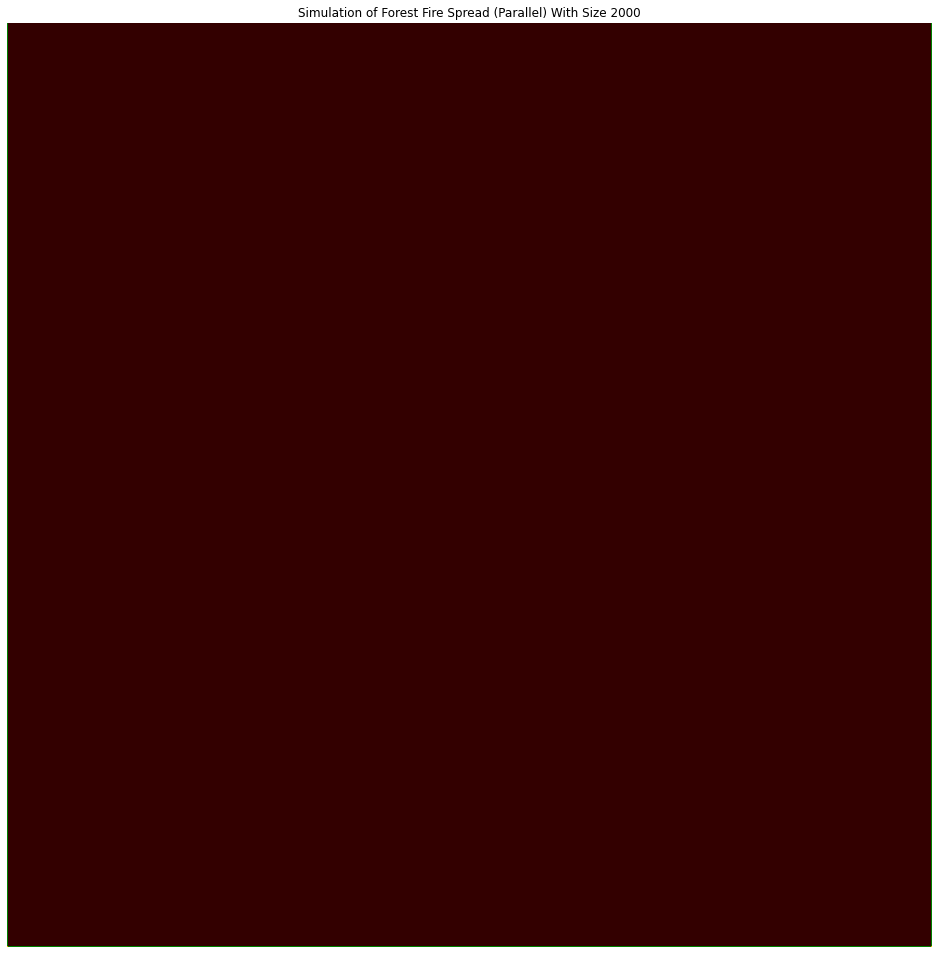

In [26]:
startTime = time.time()
gridSize = 2000
fig_no = 11

forest = initForestState_Parallel(gridSize)

forest_test = VisualizeForestFireSpread_Parallel(gridSize, forest)

timeElapsed = time.time() - startTime
print("Time elapsed for applying the spread (Parallel) on forest grid size {0}: {1} seconds".format(gridSize, timeElapsed))

fig = plt.figure(num=fig_no, figsize=(plot_size + 5, plot_size + 5))
ax = fig.add_subplot(111)
ax.set_title('Simulation of Forest Fire Spread (Parallel) With Size {0}'.format(gridSize))
ax.set_axis_off()
    
# plot the forest
forestGridVisual = ax.imshow(forest, cmap=cmap, norm=norm)
    
def animate(i):
    forestGridVisual.set_array(animate.forest)
    animate.forest = VisualizeForestFireSpread_Parallel(gridSize, animate.forest)

animate.forest = forest

anim = animation.FuncAnimation(fig, animate, interval=animation_delay, frames=frame_size)

# saving the animation as an mp4 video file
anim.save('fire_spread_animation_{0}__with_parallel.gif'.format(gridSize))

plt.show()